<a href="https://colab.research.google.com/github/ishandahal/stats453-deep_learning_torch/blob/main/Autoencoder/Conv_autoencoder_Rf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Convolutional Autoencoder and Random Forest Classifier

#### Imports

In [1]:
import time
import numpy as np
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms


if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

In [2]:
### SETTINGS
##########################

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Device:', device)

# Hyperparameters
random_seed = 123
learning_rate = 0.005
num_epochs = 10
batch_size = 128


### MNIST DATASET


custom_transform = transforms.Compose([transforms.ToTensor(),
                                       transforms.Normalize((0.5,), (0.5,))])

train_dataset = datasets.MNIST(root='data', 
                               train=True, 
                               transform=custom_transform,
                               download=True)

test_dataset = datasets.MNIST(root='data', 
                              train=False, 
                              transform=custom_transform)


train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=batch_size, 
                          shuffle=True)

test_loader = DataLoader(dataset=test_dataset, 
                         batch_size=batch_size, 
                         shuffle=False)

# Checking the dataset
for images, labels in train_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

Device: cpu


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)




Image batch dimensions: torch.Size([128, 1, 28, 28])
Image label dimensions: torch.Size([128])


#### Model

In [3]:

class ConvolutionalAutoencoder(torch.nn.Module):

    def __init__(self):
        super(ConvolutionalAutoencoder, self).__init__()
        
        # calculate same padding:
        # (w - k + 2*p)/s + 1 = o
        # => p = (s(o-1) - w + k)/2
        
        ### ENCODER
        
        # 28x28x1 => 28x28x4
        self.conv_1 = torch.nn.Conv2d(in_channels=1,
                                      out_channels=4,
                                      kernel_size=(3, 3),
                                      stride=(1, 1),
                                      # (1(28-1) - 28 + 3) / 2 = 1
                                      padding=1)
        # 28x28x4 => 14x14x4
        self.pool_1 = torch.nn.MaxPool2d(kernel_size=(2, 2),
                                         stride=(2, 2),
                                         # (2(14-1) - 28 + 2) / 2 = 0
                                         padding=0)                                       
        # 14x14x4 => 14x14x8
        self.conv_2 = torch.nn.Conv2d(in_channels=4,
                                      out_channels=8,
                                      kernel_size=(3, 3),
                                      stride=(1, 1),
                                      # (1(14-1) - 14 + 3) / 2 = 1
                                      padding=1)                 
        # 14x14x8 => 7x7x8                             
        self.pool_2 = torch.nn.MaxPool2d(kernel_size=(2, 2),
                                         stride=(2, 2),
                                         # (2(7-1) - 14 + 2) / 2 = 0
                                         padding=0)
        
        ### DECODER
                                         
        # 7x7x8 => 14x14x8               
        # Unpool

        # 14x14x8 => 14x14x8
        self.conv_3 = torch.nn.Conv2d(in_channels=8,
                                      out_channels=4,
                                      kernel_size=(3, 3),
                                      stride=(1, 1),
                                      # (1(14-1) - 14 + 3) / 2 = 1
                                      padding=1)
        # 14x14x4 => 28x28x4                            
        # Unpool
        
        # 28x28x4 => 28x28x1
        self.conv_4 = torch.nn.Conv2d(in_channels=4,
                                      out_channels=1,
                                      kernel_size=(3, 3),
                                      stride=(1, 1),
                                      # (1(28-1) - 28 + 3) / 2 = 1
                                      padding=1)
        
    def encoder(self, x):
        x = self.conv_1(x)
        x = F.leaky_relu(x)
        x = self.pool_1(x)
        x = self.conv_2(x)
        x = F.leaky_relu(x)
        x = self.pool_2(x)
        return x

    def decoder(self, x):
        x = F.interpolate(x, scale_factor=2)
        x = self.conv_3(x)
        x = F.leaky_relu(x)
        x = F.interpolate(x, scale_factor=2)
        x = self.conv_4(x)
        x = torch.tanh(x)
        return x

    def forward(self, x):

        ## Encoder
        x = self.encoder(x)

        ## Decoder
        x = self.decoder(x)
        return x

torch.manual_seed(random_seed)
model = ConvolutionalAutoencoder()
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

### Training

In [7]:
start_time = time.time()
for epoch in range(num_epochs):
    for batch_idx, (features, labels) in enumerate(train_loader):

        features = features.to(device)

        ## forward and back prop
        decoded = model(features)
        cost = F.mse_loss(decoded, features)

        optimizer.zero_grad()

        cost.backward()

        # update model parameters
        optimizer.step()

        ## logging 
        if not batch_idx % 50:
            print ('Epoch: %03d/%03d | Batch %03d/%03d | Cost: %.4f' 
                   %(epoch+1, num_epochs, batch_idx, 
                     len(train_loader), cost))
            
    print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))
    
print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

Epoch: 001/010 | Batch 000/469 | Cost: 0.9883
Epoch: 001/010 | Batch 050/469 | Cost: 0.1496
Epoch: 001/010 | Batch 100/469 | Cost: 0.0883
Epoch: 001/010 | Batch 150/469 | Cost: 0.0677
Epoch: 001/010 | Batch 200/469 | Cost: 0.0603
Epoch: 001/010 | Batch 250/469 | Cost: 0.0563
Epoch: 001/010 | Batch 300/469 | Cost: 0.0540
Epoch: 001/010 | Batch 350/469 | Cost: 0.0525
Epoch: 001/010 | Batch 400/469 | Cost: 0.0453
Epoch: 001/010 | Batch 450/469 | Cost: 0.0477
Time elapsed: 0.54 min
Epoch: 002/010 | Batch 000/469 | Cost: 0.0495
Epoch: 002/010 | Batch 050/469 | Cost: 0.0436
Epoch: 002/010 | Batch 100/469 | Cost: 0.0450
Epoch: 002/010 | Batch 150/469 | Cost: 0.0437
Epoch: 002/010 | Batch 200/469 | Cost: 0.0434
Epoch: 002/010 | Batch 250/469 | Cost: 0.0433
Epoch: 002/010 | Batch 300/469 | Cost: 0.0403
Epoch: 002/010 | Batch 350/469 | Cost: 0.0393
Epoch: 002/010 | Batch 400/469 | Cost: 0.0375
Epoch: 002/010 | Batch 450/469 | Cost: 0.0350
Time elapsed: 1.07 min
Epoch: 003/010 | Batch 000/469 | C

### Evaluation 

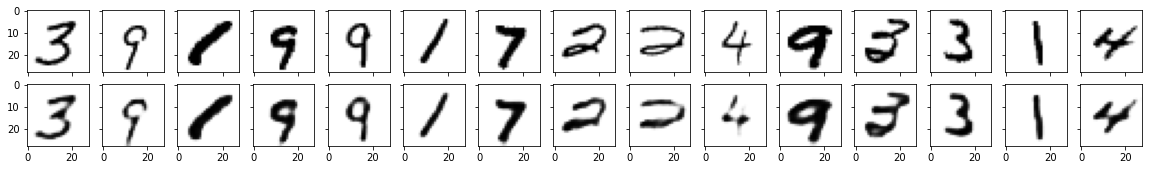

In [8]:
import matplotlib.pyplot as plt

### VISUALIZATION

n_images = 15
image_width = 28

fig, axes = plt.subplots(nrows=2, ncols=n_images, 
                         sharex=True, sharey=True, figsize=(20, 2.5))
orig_images = features[:n_images]
decoded_images = decoded[:n_images]

for i in range(n_images):
    for ax, img in zip(axes, [orig_images, decoded_images]):
        curr_img = img[i].detach().to(torch.device('cpu'))
        ax[i].imshow(curr_img.view((image_width, image_width)), cmap='binary')

#### Classifier 

In [10]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=60000,
                          shuffle=True)

test_loader = DataLoader(dataset=test_dataset,
                         batch_size=10000)

In [11]:
for images, labels in train_loader:
    print(f"Image batch dimensions: {images.size()}")
    print(f"Label batch dimensions: {labels.size()}")
    break

X_train = np.array(images.view(-1, 28*28))
y_train = np.array(labels.view(-1))

for images, labels in test_loader:
    print(f"Image batch dimensions: {images.size()}")
    print(f"Label batch dimensions: {labels.size()}")
    break

X_test = np.array(images.view(-1, 28*28))
y_test = np.array(labels.view(-1))

Image batch dimensions: torch.Size([60000, 1, 28, 28])
Label batch dimensions: torch.Size([60000])
Image batch dimensions: torch.Size([10000, 1, 28, 28])
Label batch dimensions: torch.Size([10000])


In [14]:
rf = RandomForestClassifier(n_estimators=500, n_jobs=-1).fit(X_train, y_train)

print(f"Train accuracy: {rf.score(X_train, y_train)*100}%")
print(f"Test accuracy: {rf.score(X_test, y_test)*100}%")

Train accuracy: 100.0%
Test accuracy: 97.11%


### Using PCA

In [15]:
from sklearn.decomposition import PCA

pca = PCA(n_components=7*7*8) # same no as latent space of the autoencoder
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

In [18]:
rf = RandomForestClassifier(n_estimators=500, n_jobs=-1).fit(X_train_pca, y_train)
print('Random Forest Classifier after PCA of the dataset\n')
print(f"Train accuracy: {rf.score(X_train_pca, y_train)*100}%")
print(f"Test accuracy: {rf.score(X_test_pca, y_test)*100}%")

Random Forest Classifier after PCA of the dataset

Train accuracy: 100.0%
Test accuracy: 94.55%


### Compressed MNIST

In [22]:
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=1000,
                          shuffle=True)

test_loader = DataLoader(dataset=test_dataset,
                         batch_size=1000)

In [25]:
X_train_compr = np.zeros((60000, 7*7*8))
y_train = np.zeros(60000)

start_idx = 0

for images, labels in train_loader:
    features = images.to(device)

    with torch.no_grad():
        encoded = model.encoder(features)

    X_train_compr[start_idx:start_idx+1000] = encoded.view(-1, 7*8*7).to(torch.device('cpu')).numpy()
    y_train[start_idx:start_idx+1000] = labels

    start_idx += 1000

In [27]:
X_test_compr = np.zeros((10000, 7*8*7))
y_test = np.zeros(10000)

start_idx = 0

for images, labels in test_loader:
    
    features = images.to(device)
    encoded = model.encoder(features)

    with torch.no_grad():
        X_test_compr[start_idx:start_idx+1000] = encoded.view(-1, 7*7*8).to(torch.device('cpu')).numpy()
        y_test[start_idx:start_idx+1000] = labels

        start_idx += 1000

In [28]:
print(X_test_compr.shape)
print(X_train_compr.shape)

(10000, 392)
(60000, 392)


In [29]:
rf = RandomForestClassifier(n_estimators=500, n_jobs=-1).fit(X_train_compr, y_train)

print('Random Forest Classifier after reducing the dimensions of the dataset by autoencoder\n')
print(f"Train accuracy: {rf.score(X_train_compr, y_train)*100}%")
print(f"Test accuracy: {rf.score(X_test_compr, y_test)*100}%")

Random Forest Classifier after reducing the dimensions of the dataset by autoencoder

Train accuracy: 100.0%
Test accuracy: 96.32%


This accuracy is inferor to Randomforest with the original dataset by a bit, however given that the domension of the data was reduced significantly it is still pretty good.